# INA Project

The data used was obtained from [here](https://zenodo.org/records/47317).
The files used contain network models of the European high-voltage power grid, extracted by [GridKit](https://github.com/bdw/GridKit). These extracts form a topological network with stations in one file (nodes.csv) and lines in another (edges.csv). OpenStreetMap is the primary data source.

Motivation (i think): On the (put date) there was a major blackout of the Iberian Peninsula for a long period of time, this led us to think of how fragile can the European Electrical Grid be

Objectives? Guys at first i thought that we needed voltage to be able to do the second part of taking the type of the nodes into consideration but now I do not think so. The first part will be just treating the network as if all nodes are of the same type and perform attacks to check connectivity. Then the second part we will do almost the same think but after the attacks check the power of a node. It will have no power if there is not a path to a plant, du to this we will do specific attacks on plants and on substations (substations will disconnect paths to the plant), We can also do attacks on edges for all cases as they are cables and in real life we can obviously attack, we can even say that edges are easier to attack, but also easier to rebuild. 


When I ran the map with the types of nodes I see very little plants which might be concerning. We can first take all the nodes that do not have a path to a plant and only then we start the first part, doing this we are basically getting the LCC that has energy. But this is just an ideia maybe everything is connected. 

In [30]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.basemap import Basemap
from operator import itemgetter
import random
#from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme()

## Creating the Graph from the data

In [21]:
node_csv = 'data/nodes.csv'
edge_csv = 'data/edges.csv'
# 1) Read node data
nodes = pd.read_csv(node_csv, usecols=[
    "v_id", "lon", "lat", "typ", "name", "operator" # voltage and freq if needed
])
    
# 2) Read edge data
edges = pd.read_csv(edge_csv, usecols=["v_id_1", "v_id_2"])
    
# 3) Build graph
G = nx.Graph()
    
# 3a) Add nodes with attributes
for _, row in nodes.iterrows():
    # parse voltage list and frequency
    '''voltage_str = str(row.voltage)
    if voltage_str and voltage_str != 'nan':
        voltages = [int(v) for v in voltage_str.split(";") if v]
    else:
        voltages = []  # will be inferred later
    #freq = float(row.frequency) if pd.notna(row.frequency) else None
    #   plant       → generation
    #   substation  → transmission
    #   transformer → distribution
    #   joint       → transmission'''
    typ_lower = row.typ.lower() if isinstance(row.typ, str) else ""
    if typ_lower == "plant":
        role = "generation"
    elif typ_lower in ("substation", "sub_station", "station"):
        role = "conversion"
    elif typ_lower in ("joint", "merge"):
            role = "transmission"
    else:
        role = "unknown"
        
    G.add_node(
        row.v_id,
        pos=(row.lon, row.lat),
        typ=row.typ,
        role=role,
        #voltages=voltages,
        #frequency=freq,
        name=row.name,
        operator=row.operator
    )
    
# 3b) Add edges
for _, row in edges.iterrows():
    G.add_edge(row.v_id_1, row.v_id_2)


In [ ]:
'''# some stations have no voltage we will use the neighbours voltage
def infer_node_voltage_from_neighbors(G:nx.Graph):
    for node, data in G.nodes(data=True):
        if not data.get('voltages'):
            # Look at neighbors and their voltages
            neighbor_voltages = []
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor].get('role')!= 'conversion':
                    for v in G.nodes[neighbor].get('voltages'):
                        neighbor_voltages.append(v)
            if neighbor_voltages:
                # Most common voltage
                inferred = set(neighbor_voltages)
                G.nodes[node]['voltages'] = list(inferred)

infer_node_voltage_from_neighbors(G)
infer_node_voltage_from_neighbors(G)
infer_node_voltage_from_neighbors(G)'''

In [18]:
stations = set()
generation = 0
conversion = 0
transmission = 0
uk = 0
for _, i in G.nodes(data=True):
    typ = i.get('typ')
    role = i.get('role')
    if role == 'generation':
        generation += 1
    elif role == 'conversion':
        conversion += 1
    elif role == 'transmission':
        transmission += 1
    else:
        uk +=1
    stations.add(typ)
print("Types of stations: ", stations)
print("Number of generation stations: ", generation)
print("Number of conversion stations: ", conversion)
print("Number of transmission stations: ", transmission)
print("Unknown stations: ", uk)


Types of stations:  {'joint', 'plant', 'sub_station', 'station', 'merge', 'substation'}
Number of generation stations:  120
Number of conversion stations:  6398
Number of transmission stations:  7353
Unknown stations:  0


### Station Types from GridKit (OpenStreetMap)

| **Type**        | **Assigned Role**    | **Explanation** |
|-----------------|----------------------|------------------|
| `plant`         | **generation**       | A power generation facility, such as a nuclear, hydroelectric, wind, or solar plant. These facilities are tagged as `power=plant` in OSM and are responsible for producing electricity that is fed into the grid. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=plant) |
| `substation`    | **conversion**     | A facility that transforms voltage levels and routes electricity within the transmission network. Tagged as `power=substation` in OSM, substations can vary in function, including switching, voltage transformation, and compensation. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=substation) |
| `sub_station`   | **conversion**     | same as substation, just a different labeling |
| `joint`         | **transmission**     | Represents a junction point in the power network where multiple lines connect. In OSM, such points are often tagged as `power=switch` or `power=busbar`, depending on their specific function. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=switch) |
| `merge`         | **transmission**     | Similar to `joint`, this represents a point where multiple power lines converge. It may correspond to a `power=busbar` or similar component in OSM, facilitating the merging of electrical paths. |
| `station`       | **conversion**        | The tag `power=station` is deprecated in OSM due to its ambiguity. It was previously used for both power plants and substations but it was supossed to refer to substations so we will consider that. Current best practices recommend using `power=plant` for generation facilities and `power=substation` for substations. [OSM Source](https://wiki.openstreetmap.org/wiki/Tag:power=station) |

Visualizing the network on a map

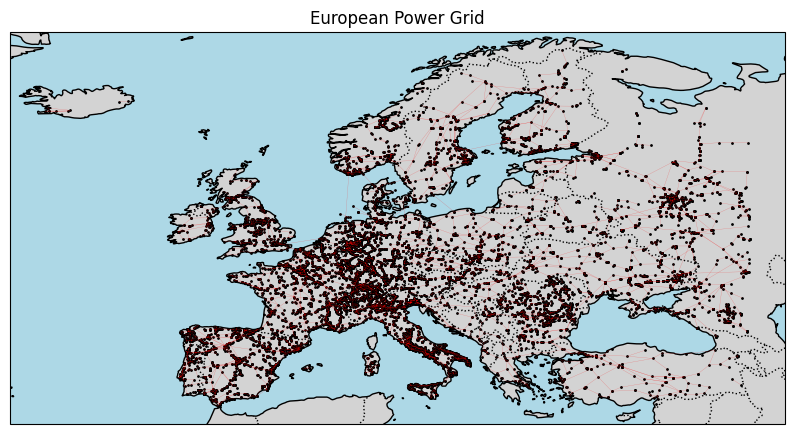

In [13]:
title="European Power Grid"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)
    
# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G.edges():
    x1, y1 = G.nodes[u]['pos']
    x2, y2 = G.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes
xs = [data['pos'][0] for _, data in G.nodes(data=True)]
ys = [data['pos'][1] for _, data in G.nodes(data=True)]
ax.scatter(xs, ys, s=1, color='black', transform=ccrs.PlateCarree())

plt.show()


Visualizing the diferent types of stations

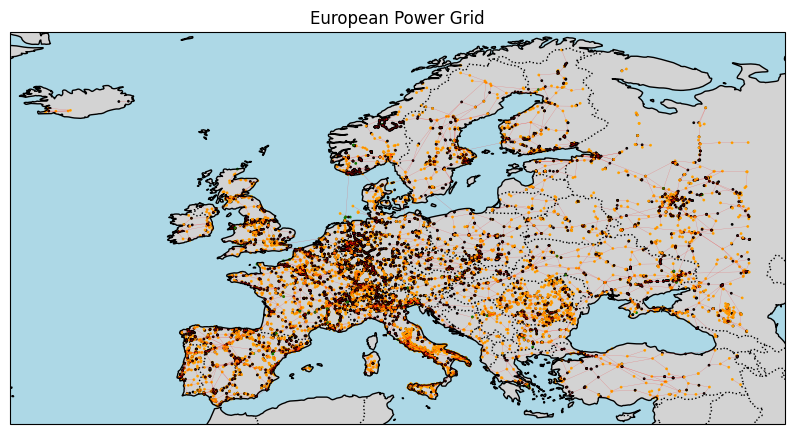

In [14]:
title="European Power Grid"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)
    
# Preparing the colors
color_map = {
    "generation": "green",
    "transmission": "black",
    "conversion": "orange",
    "unknown": "gray"
}

colors = [color_map.get(data.get("role", "unknown"), "gray") for _, data in G.nodes(data=True)]



# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G.edges():
    x1, y1 = G.nodes[u]['pos']
    x2, y2 = G.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes
xs = [data['pos'][0] for _, data in G.nodes(data=True)]
ys = [data['pos'][1] for _, data in G.nodes(data=True)]
ax.scatter(xs, ys, s=1, color=colors, transform=ccrs.PlateCarree())

plt.show()


## 1st Analysis
### Graph Analysis

As our network is an infrastructure we expect some characteristics:

- Low average degree: Most nodes connect to 1-3 neighbours
- Low clustering coefficient: Few triangles, Infraestructure networks are "tree-like" for redundancy and cost reasons. This makes even more sense for an eletrical grid comparing for example with a highways network.
- High average path length: Long routes from one node to another due to physical/geographic constraints
- Degree distribuition: Exponential or truncated power law. Hubs exist, but extreme hubs (like in social networks) are rare due to physical/engineering limits
- Geographical: Layout respects geography, unlike abstract graphs like the internet 
- Robust yet fragile: Robust to random failure, fragile to targeted attacks (like hubs or plants)

In [27]:
def info(G):
  print("{:>12s} | '{:s}'".format('Graph', G.name))

  n = G.number_of_nodes()
  m = G.number_of_edges()
  
  print("{:>12s} | {:,d} ({:,d})".format('Nodes', n, nx.number_of_isolates(G)))
  print("{:>12s} | {:,d} ({:,d})".format('Edges', m, nx.number_of_selfloops(G)))
  print("{:>12s} | {:.2f} ({:,d})".format('Degree', 2 * m / n, max(k for _, k in G.degree())))
  
  C = sorted(nx.connected_components(G), key = len, reverse = True)

  print("{:>12s} | {:.1f}% ({:,d})".format('LCC', 100 * len(C[0]) / n, len(C)))

  if isinstance(G, nx.MultiGraph):
    G = nx.Graph(G)

  print("{:>12s} | {:.4f}".format('Clustering', nx.average_clustering(G)))
  print()
  
  return G


In [28]:
info(G)

       Graph | ''
       Nodes | 13,871 (27)
       Edges | 17,277 (0)
      Degree | 2.49 (16)
         LCC | 97.2% (86)
  Clustering | 0.0893



In [24]:
connected_components = list(nx.connected_components(G))

# Número de componentes conectados
num_connected_components = len(connected_components)
print("\nNumber of connected components:\n", num_connected_components)
# reducing to the largest connected component but keeping the result as a graph

G_reduced = G.subgraph(max(nx.connected_components(G), key=len))
print("\nNumber of nodes in the largest connected component:\n", len(G_reduced.nodes()))
print("\nNumber of edges in the largest connected component:\n", len(G_reduced.edges()))
# ratios compared with orginal graph
print("\nRatio of nodes in the largest connected component:\n", len(G_reduced.nodes())/len(G.nodes()))
print("\nRatio of edges in the largest connected component:\n", len(G_reduced.edges())/len(G.edges()))


Number of connected components:
 86

Number of nodes in the largest connected component:
 13478

Number of edges in the largest connected component:
 16922

Ratio of nodes in the largest connected component:
 0.971667507749982

Ratio of edges in the largest connected component:
 0.979452451235747


In [ ]:
info(G_reduced)

       Graph | ''
       Nodes | 13,478 (0)
       Edges | 16,922 (0)
      Degree | 2.51 (16)
         LCC | 100.0% (1)
  Clustering | 0.0891



In [39]:
stations = set()
generation = 0
conversion = 0
transmission = 0
uk = 0
for _, i in G_reduced.nodes(data=True):
    typ = i.get('typ')
    role = i.get('role')
    if role == 'generation':
        generation += 1
    elif role == 'conversion':
        conversion += 1
    elif role == 'transmission':
        transmission += 1
    else:
        uk +=1
    stations.add(typ)
print("Types of stations: ", stations)
print("Number of generation stations: ", generation)
print("Number of conversion stations: ", conversion)
print("Number of transmission stations: ", transmission)
print("Unknown stations: ", uk)

Types of stations:  {'joint', 'plant', 'sub_station', 'station', 'merge', 'substation'}
Number of generation stations:  116
Number of conversion stations:  6162
Number of transmission stations:  7200
Unknown stations:  0


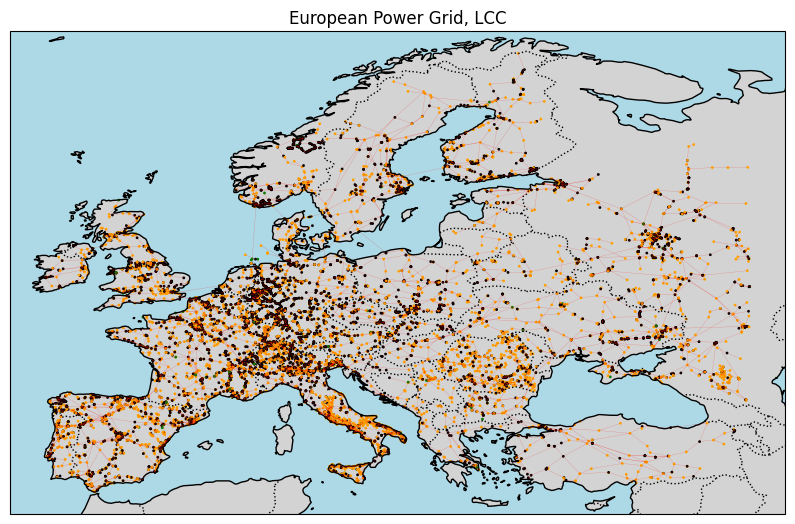

In [23]:
title="European Power Grid, LCC"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)
    
# Preparing the colors
color_map = {
    "generation": "green",
    "transmission": "black",
    "conversion": "orange",
    "unknown": "gray"
}

colors = [color_map.get(data.get("role", "unknown"), "gray") for _, data in G_reduced.nodes(data=True)]



# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G_reduced.edges():
    x1, y1 = G_reduced.nodes[u]['pos']
    x2, y2 = G_reduced.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes
xs = [data['pos'][0] for _, data in G_reduced.nodes(data=True)]
ys = [data['pos'][1] for _, data in G_reduced.nodes(data=True)]
ax.scatter(xs, ys, s=1, color=colors, transform=ccrs.PlateCarree())

plt.show()

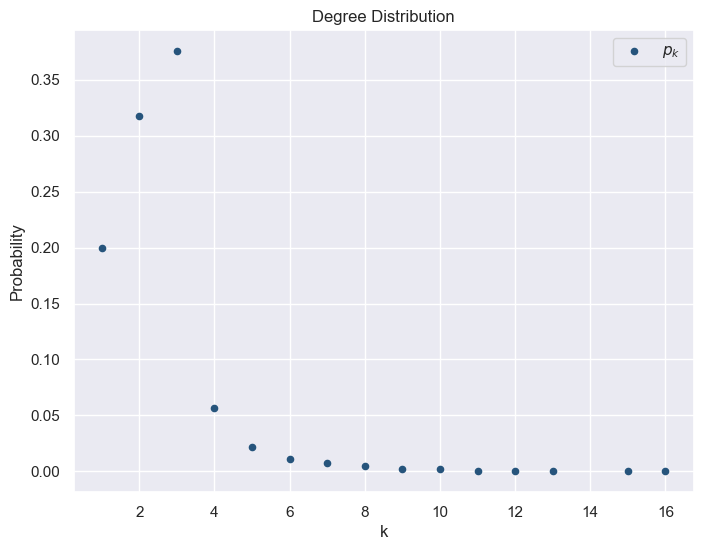

In [38]:
degree = np.array([d for _, d in G_reduced.degree()])
unique_degree, counts = np.unique(degree, return_counts=True)
degree_distribution = counts / counts.sum()

ball_size = 20

# plot
plt.figure(figsize=(8,6))
plt.scatter(unique_degree, degree_distribution, label=r"$p_{k}$", color='#26547C', s=ball_size)
plt.xlabel(r'k')
plt.ylabel("Probability")
plt.title("Degree Distribution")
plt.legend()
plt.show()

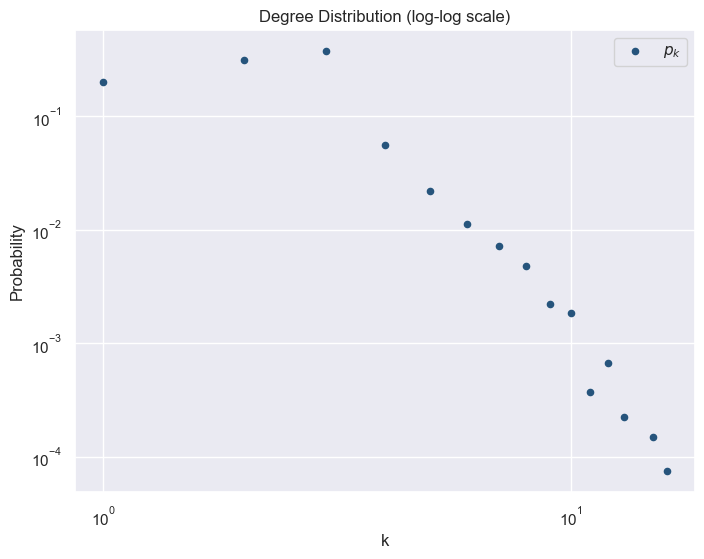

In [35]:

plt.figure(figsize=(8,6))
plt.scatter(unique_degree, degree_distribution, label=r"$p_{k}$", color='#26547C', s=ball_size)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'k')
plt.ylabel("Probability")
plt.title("Degree Distribution (log-log scale)")
plt.legend()
plt.show()

In [43]:
avg_path_length = nx.average_shortest_path_length(G_reduced)
print("Average shortest path length:", round(avg_path_length, 2))
diameter = nx.diameter(G_reduced)
print("Graph diameter:", diameter)



KeyboardInterrupt: 

### Centrality Measures

In [ ]:
def pagerank(G, alpha = 0.85, eps=10e-3):
    P = np.array([1/len(G)]*len(G))
    diff = 1
    while diff > eps:
        U = np.zeros(len(G))

        for i in G.nodes():
            for j in G[i]: # for directed go trough predecessors
                U[i] = U[i] + P[j] * alpha / G.degree(j) # we want out degree. If we have weighted graph for each predecessor (neighbour) multiply by the weight and then divide by sum of weights instead of degree
        u = U.sum()

        for i in G.nodes(): 
            U[i] = U[i] + (1 - u) / len(G)
        
        diff = np.absolute(U - P).sum()

        P = U

    return {i : P[i] for i in G.nodes}

In [ ]:
# Compute centralities
deg_cent = nx.degree_centrality(G_reduced)
btw_cent = nx.betweenness_centrality(G_reduced, normalized=True)
clo_cent = nx.closeness_centrality(G_reduced)
prank_cent = pagerank(G_reduced)
edge_btw = nx.edge_betweenness_centrality(G_reduced, normalized=True)
edge_btw = nx.edge_betweenness_centrality(G_reduced, normalized=True)

# Show top 5 nodes for each
def top_nodes(cent_dict, name, n=5):
    print(f"\nTop {n} nodes by {name}:")
    for node, score in sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"  Node {node}: {score:.4f}")

top_nodes(deg_cent, "Degree Centrality")
top_nodes(btw_cent, "Betweenness Centrality")
top_nodes(clo_cent, "Closeness Centrality")
top_nodes(prank_cent, "Pagerank Centrality")
# Sort and print top N
top_edges = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 edges by betweenness centrality, nodes it connects:")
for (u, v), score in top_edges:
    print(f"  {u} <--> {v}: {score:.5f}")


degree_centrality


In [ ]:
centrality_key = 'deg_cent' 

# Extract positions and centrality values
xs = []
ys = []
sizes = []

# Normalize centrality values for node sizing
cent_values = [data.get(centrality_key, 0) for _, data in G_reduced.nodes(data=True)]
min_cent, max_cent = min(cent_values), max(cent_values)
cent_range = max_cent - min_cent if max_cent > min_cent else 1e-6  # avoid division by zero

for _, data in G_reduced.nodes(data=True):
    x, y = data['pos']
    c = data.get(centrality_key, 0)
    size = 1 + 300 * (c - min_cent) / cent_range  # scale size for visibility
    xs.append(x)
    ys.append(y)
    sizes.append(size)

# Plot
title = "European Power Grid (Node Size ∝ Degree Centrality)"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)

# Map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G_reduced.edges():
    x1, y1 = G_reduced.nodes[u]['pos']
    x2, y2 = G_reduced.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes with size based on centrality
ax.scatter(xs, ys, s=sizes, c='black', alpha=0.8, transform=ccrs.PlateCarree())

plt.show()

betweenness centrality

In [ ]:
centrality_key = 'btw_cent' 

# Extract positions and centrality values
xs = []
ys = []
sizes = []

# Normalize centrality values for node sizing
cent_values = [data.get(centrality_key, 0) for _, data in G_reduced.nodes(data=True)]
min_cent, max_cent = min(cent_values), max(cent_values)
cent_range = max_cent - min_cent if max_cent > min_cent else 1e-6  # avoid division by zero

for _, data in G_reduced.nodes(data=True):
    x, y = data['pos']
    c = data.get(centrality_key, 0)
    size = 1 + 300 * (c - min_cent) / cent_range  # scale size for visibility
    xs.append(x)
    ys.append(y)
    sizes.append(size)

# Plot
title = "European Power Grid (Node Size ∝ Betweenness Centrality)"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)

# Map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G_reduced.edges():
    x1, y1 = G_reduced.nodes[u]['pos']
    x2, y2 = G_reduced.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes with size based on centrality
ax.scatter(xs, ys, s=sizes, c='black', alpha=0.8, transform=ccrs.PlateCarree())

plt.show()

closeness centrality

In [ ]:
centrality_key = 'clo_cent' 

# Extract positions and centrality values
xs = []
ys = []
sizes = []

# Normalize centrality values for node sizing
cent_values = [data.get(centrality_key, 0) for _, data in G_reduced.nodes(data=True)]
min_cent, max_cent = min(cent_values), max(cent_values)
cent_range = max_cent - min_cent if max_cent > min_cent else 1e-6  # avoid division by zero

for _, data in G_reduced.nodes(data=True):
    x, y = data['pos']
    c = data.get(centrality_key, 0)
    size = 1 + 300 * (c - min_cent) / cent_range  # scale size for visibility
    xs.append(x)
    ys.append(y)
    sizes.append(size)

# Plot
title = "European Power Grid (Node Size ∝ Closeness Centrality)"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)

# Map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G_reduced.edges():
    x1, y1 = G_reduced.nodes[u]['pos']
    x2, y2 = G_reduced.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes with size based on centrality
ax.scatter(xs, ys, s=sizes, c='black', alpha=0.8, transform=ccrs.PlateCarree())

plt.show()

page rank

In [ ]:
centrality_key = 'p_rank' 

# Extract positions and centrality values
xs = []
ys = []
sizes = []

# Normalize centrality values for node sizing
cent_values = [data.get(centrality_key, 0) for _, data in G_reduced.nodes(data=True)]
min_cent, max_cent = min(cent_values), max(cent_values)
cent_range = max_cent - min_cent if max_cent > min_cent else 1e-6  # avoid division by zero

for _, data in G_reduced.nodes(data=True):
    x, y = data['pos']
    c = data.get(centrality_key, 0)
    size = 1 + 300 * (c - min_cent) / cent_range  # scale size for visibility
    xs.append(x)
    ys.append(y)
    sizes.append(size)

# Plot
title = "European Power Grid (Node Size ∝ Page Rank)"
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title)

# Map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw edges
for u, v in G_reduced.edges():
    x1, y1 = G_reduced.nodes[u]['pos']
    x2, y2 = G_reduced.nodes[v]['pos']
    ax.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=0.4, transform=ccrs.Geodetic())

# Draw nodes with size based on centrality
ax.scatter(xs, ys, s=sizes, c='black', alpha=0.8, transform=ccrs.PlateCarree())

plt.show()

edge betweenness

In [ ]:
nx.set_edge_attributes(G_reduced, edge_btw, "btw_centrality")
def plot_edge_betweenness_map(G, title='Edge Betweenness Centrality Map'):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(title)

    # Base map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Normalize edge centrality values
    edge_centralities = [G[u][v].get("btw_centrality", 0) for u, v in G.edges()]
    min_c = min(edge_centralities)
    max_c = max(edge_centralities)
    edge_range = max_c - min_c if max_c > min_c else 1e-6

    for u, v in G.edges():
        x1, y1 = G.nodes[u]['pos']
        x2, y2 = G.nodes[v]['pos']
        c = G[u][v].get("btw_centrality", 0)
        lw = 0.2 + 3 * (c - min_c) / edge_range  # scale from 0.2 to ~3.2
        ax.plot([x1, x2], [y1, y2], color='red', linewidth=lw, alpha=0.7, transform=ccrs.Geodetic())

    # Draw nodes
    xs = [data['pos'][0] for _, data in G.nodes(data=True)]
    ys = [data['pos'][1] for _, data in G.nodes(data=True)]
    ax.scatter(xs, ys, s=1, color='black', transform=ccrs.PlateCarree())

    plt.show()

plot_edge_betweenness_map(G_reduced)

### Attacks

In [ ]:
def simulate_node_attacks(G, strategies, steps=100, role=None):
    """
    Simulates node removals based on centrality strategies.

    """
    results = {}

    for strategy_name, scores in strategies.items():
        G_copy = G.copy()

        if strategy_name == 'random':
            node_pool = [n for n in G_copy.nodes() if (role is None or G_copy.nodes[n].get('role') == role)]
            random.shuffle(node_pool)
            node_order = node_pool
        else:
            filtered_scores = {n: s for n, s in scores.items() if (role is None or G.nodes[n].get('role') == role)}
            node_order = [n for n, _ in sorted(filtered_scores.items(), key=lambda x: x[1], reverse=True)]

        num_components = []
        for i in range(min(steps, len(node_order))):
            G_copy.remove_node(node_order[i])
            num_components.append(nx.number_connected_components(G_copy))

        results[strategy_name] = num_components

    return results


def plot_attack_simulation(results, role=None):
    plt.figure(figsize=(10, 6))
    for name, comps in results.items():
        plt.plot(range(len(comps)), comps, label=name)
    plt.xlabel("Number of nodes removed")
    plt.ylabel("Number of connected components")
    if role:
        plt.title(f"Network Fragmentation Under Targeted and Random Node Attacks (removing nodes of role: {role})")
    else:
        plt.title("Network Fragmentation Under Targeted and Random Node Attacks")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
centrality_strategies = {
    'degree': deg_cent,
    'betweenness': btw_cent,
    'closeness': clo_cent,
    'random': {}  # empty dict triggers shuffle
}

results = simulate_node_attacks(G, centrality_strategies, role = None, steps=100)
plot_attack_simulation(results, role=None)

results_generation = simulate_node_attacks(G, centrality_strategies, role = 'generation', steps=100)
plot_attack_simulation(results_generation, role='generation')

results_conversion = simulate_node_attacks(G, centrality_strategies, role = 'conversion', steps=100)
plot_attack_simulation(results_conversion, role='conversion')

results_transmission = simulate_node_attacks(G, centrality_strategies, role = 'transmission', steps=100)
plot_attack_simulation(results_transmission, role='transmission')

Edge attack

In [ ]:
def simulate_edge_attacks(G, strategies, steps=100):
    """
    Simulates edge removals based on different centrality strategies.
    
    """
    results = {}

    for strategy_name, scores in strategies.items():
        G_copy = G.copy()
        if strategy_name == 'random':
            edge_order = list(G_copy.edges())
            random.shuffle(edge_order)
        else:
            edge_order = [e for e, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]

        num_components = []
        for i in range(steps):
            if i >= len(edge_order):
                break
            u, v = edge_order[i]
            if G_copy.has_edge(u, v):
                G_copy.remove_edge(u, v)
            num_components.append(nx.number_connected_components(G_copy))

        results[strategy_name] = num_components

    return results

def plot_edge_attack_simulation(results):
    plt.figure(figsize=(10, 6))
    for name, comps in results.items():
        plt.plot(range(len(comps)), comps, label=name)
    plt.xlabel("Number of edges removed")
    plt.ylabel("Number of connected components")
    plt.title("Network Fragmentation Under Targeted and Random Edge Attacks")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
edge_strategies = {
    'betweenness': edge_btw,
    'random': {}
}

edge_results = simulate_edge_attacks(G, edge_strategies, steps=100)
plot_edge_attack_simulation(edge_results)

## 2nd Analysis

The main difference of this analysis is that when attacking we will evaluate the number of nodes that still have eletricity basically. For this one I think we can also make some plots were we showcase the light and dark zones 

In [ ]:
# This is the funtion to determine if a node has eletricity


def has_electricity(G, generators, node):
    """
    Returns True if the node is a generator or is connected to at least one generator.
    """
    if node not in G:
        return False  # node doesn't exist

    if G.nodes[node].get('role') == 'generation':
        return True

    # Check if there's a path from node to any generator
    for gen in generators:
        if nx.has_path(G, source=node, target=gen):
            return True

    return False


# to use we generate the generators like this:
generators = {n for n, d in G.nodes(data=True) if d.get('role') == 'generation' and n in G}
# this happens because we will remove nodes and if they are a generator the list will change
